## EqLock: Statistics of Earthquakes and Detector Lockloss

**Inputs:**
* Channels: choose frequency band and ETM/ITM channels of interest
* Parameters: (Section 1) start time of all data, duration of all data; (2) the required width of peaks, prominience of peaks, and horizontal distance between peaks; (3) interval before/after peak to find earthquake, maximum lock value; and (5) bins to plot probability.

**Outputs:**
* Statistics: date of peak, if earthquake event (peak) broke lock, time of peak, vertical ground velocity, horizontal ground velocity, ratio vert./horiz. velocity, time of lockloss, and the vertical and horizontal velocities at time of lockloss.
* Plots: vertical vs. horizontal ground velocities, probability of surviving an earthquake of certain magnitude

In [1]:
import pandas as pd
import numpy as np

from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from scipy.signal import find_peaks
from datetime import date
from gwpy.time import tconvert
from gwpy.time import from_gps
from numpy import sqrt
import math
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"
%matplotlib inline

In [2]:
#data parameters

start_time = 1243382418 #June 1-30, 2019
duration = 24*3600*30 #30 days in Sep #can also use GPS (end time - start time)

#vertical + horizontal channels for end stations ETMX, ETMY and inner station ITMY
#first 3 are Z-channels, then X and Y for each station
channel = 'L1:ISI-GND_STS_'
channels = ['ETMX_Z', 'ETMY_Z', 'ITMY_Z', 'ETMX_X','ETMX_Y', 'ETMY_X', 'ETMY_Y', 'ITMY_X', 'ITMY_Y'] #first 3 are Z-channels, then X and Y for each station
band = '_BLRMS_30M_100M.max' #earthquake band 0.03-0.1 Hz

#choose name and location of csv data files
#keep date, frequency, and location in file name
bandfname = "eqlock_data/eqdata_jun2019_30M_100M_LA.csv"
lockfname = "eqlock_data/lbdata_jun2019_LA.csv"

### Section 1: Get earthquake and lockbit data
* Import the time series of the seismic motion and lock data as minute trends, then the resulting dataframes are saved to CSV files.
* Note on efficiency: This is most time-consuming part of code!
    * For one month of data, it takes between 1.5-4.5 hours (typically ~3 hours) to get the seismic TimeSeries and 10-30 minutes to get lockbit TimeSeries data.
    * If importing large amounts of data, I recommend breaking it up and repeating Sections 1, 2, and 3. If separated by month, for example, Section 1 saves two csv files (seismic and lock data) for each month. Section 2 then loads the data from these csv files, and Section 3 gathers statistics for this time interval.

In [3]:
%%time
#time this cell to understand efficiency

#get time series in earthquake band ground motion
channelRMS = []
for chn in channels:
    chname = channel + chn + band
    data = TimeSeries.find(chname, start_time, start_time + duration, frametype ='L1_M', verbose=True) #L1_M is minute-trend
    channelRMS.append(data.value)

Reading L1_M frames: |██████████| 513/513 (100%) ETA 00:00 
Reading L1_M frames: |██████████| 513/513 (100%) ETA 00:00 
Reading L1_M frames: |██████████| 513/513 (100%) ETA 00:00 
Reading L1_M frames: |██████████| 513/513 (100%) ETA 00:00 
Reading L1_M frames: |██████████| 513/513 (100%) ETA 00:00 
Reading L1_M frames: |██████████| 513/513 (100%) ETA 00:00 
Reading L1_M frames: |██████████| 513/513 (100%) ETA 00:00 
Reading L1_M frames: |██████████| 513/513 (100%) ETA 00:00 
Reading L1_M frames: |██████████| 513/513 (100%) ETA 00:00 
CPU times: user 1h 19min 20s, sys: 4min 32s, total: 1h 23min 52s
Wall time: 1h 28min 45s


In [5]:
#store earthquake data
eqdata = pd.DataFrame(np.transpose(channelRMS), columns = [channels])

In [6]:
#save to csv 
eqdata.to_csv(bandfname)

In [7]:
%%time
#find time series for lockbit data

lockstate = []
lockbit_ts = TimeSeries.find('L1:GRD-ISC_LOCK_STATE_N.min',start_time, start_time + duration, frametype ='L1_M', verbose=True) #minute-trend
lockstate.append(lockbit_ts.value)

Reading L1_M frames: |██████████| 513/513 (100%) ETA 00:00 
CPU times: user 8min 20s, sys: 28.8 s, total: 8min 49s
Wall time: 9min 30s


In [8]:
#store lockbit data
lbdata = pd.DataFrame(np.transpose(lockstate)) 

In [9]:
#save to csv
lbdata.to_csv(lockfname) 

### Section 2: Combine data & find earthquakes
* Three key parameters set here (width, prominence, and distance) define what is considered a peak in the data, thus what characterizes an earthquake. Use these parameters as arguments in the find_peaks command.
* If peaks are common to 2 or more of the 3 vertical channels, it is categorized as an earthquake. The earthquakes can then be plotted along with the seismic data.

In [3]:
#set parameters to use with find_peaks command
peakwidth = 5 
peakprom = 100
peakdist = 120

In [197]:
#get earthquake dataframe from file
lockbitdf = pd.read_csv(lockfname)
eqdatadf = pd.read_csv(bandfname)

In [198]:
peaksRMSix = [] #find location of local peaks in each Z-channel

for i in channels[0:3]: #just first 3 channels, in this example
    peaksix,_ = find_peaks(eqdatadf[i], width = peakwidth, distance = peakdist, prominence = peakprom)
    peaksRMSix.append(peaksix)

peaksRMSix

[array([  143,  2681,  5170,  6701, 10002, 10742, 11901, 12773,
        12899, 13841, 14039, 14170, 16290, 18223, 18731, 19041,
        19205, 20372, 20881, 21901, 23164, 25647, 26334, 26485,
        27794, 28947, 30594]),
 array([  137,  2682,  4239,  5170,  6701, 10023, 10743, 11900,
        12773, 12899, 13841, 14039, 14170, 16290, 17287, 18223,
        18731, 19041, 19205, 20365, 20881, 21901, 23164, 25647,
        26334, 26485, 28947, 30449, 30732]),
 array([  143,  2682,  5170,  6701, 10130, 10319, 10742, 11900,
        12773, 13841, 14039, 14170, 16290, 18223, 18731, 19041,
        19205, 20362, 20881, 21902, 23164, 25647, 26334, 26485,
        28947])]

In [199]:
#find common peaks in at least two of the three Z-channels, define those as earthquakes (EQs)
EQix = []

EQix.append(np.intersect1d(peaksRMSix[0],peaksRMSix[1]))
EQix.append(np.intersect1d(peaksRMSix[1],peaksRMSix[2]))
EQix.append(np.intersect1d(peaksRMSix[2],peaksRMSix[0]))

EQix = np.unique(np.concatenate(EQix))
EQix #returns location of each EQ peak in minutes from the start time

array([  143,  2682,  5170,  6701, 10742, 11900, 12773, 12899,
       13841, 14039, 14170, 16290, 18223, 18731, 19041, 19205,
       20881, 21901, 23164, 25647, 26334, 26485, 28947])

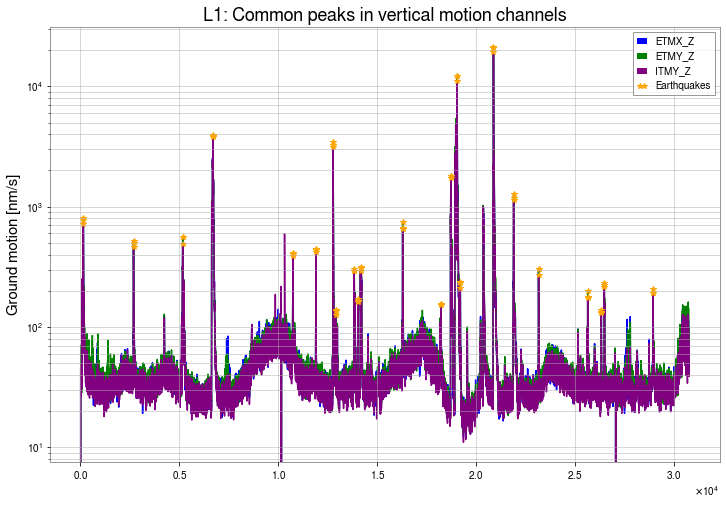

In [200]:
#plot common peaks in ETMX_Z, ETMY_Z, and ITMY_Z
plt.figure(figsize=(12,8))
plt.title('L1: Common peaks in vertical motion channels',fontsize=18)

#plot ground motion
colors = ['blue','green','purple']
for jj in range(3): #just first 3 channels, in this example
    plt.plot(eqdatadf[channels[jj]], color = colors[jj])

#plot earthquakes
for jj in range(3):
    for i in range(len(EQix)): #loop over common EQ peaks
        plt.plot(EQix[i], eqdatadf[channels[jj]][EQix[i]], '*', color = 'orange')

plt.grid(True, which="both")
plt.legend(['ETMX_Z', 'ETMY_Z', 'ITMY_Z', 'Earthquakes'])
labels = ['06-01', '06-08', '06-15', '06-22', '06-29'] #labels for each week
plt.xticks(np.arange(0, len(eqdatadf)+1, step=10080), labels)
plt.xlabel('Time from %s 00:00:00 UTC' % date.isoformat(from_gps(start_time)), fontsize=15)
plt.ylabel('Ground motion [nm/s]',fontsize=15)
plt.yscale('log')
plt.show()

### Section 3: Get statistics
* Step through a chosen interval to find if and when the detector loses lock.
* The delta parameter refers to the time interval around a peak in seismic motion data, where the number represents the number of minutes either before or after the peak. The total time interval is therefore 2 x delta.
* The statistics found for each earthquake peak are the following: date of peak, yes/no if earthquake broke lock, time of peak, vertical ground velocity, horizontal ground velocity, ratio of vertical/horizontal velocities, and also for the earthquakes that did not survive, the time of lost lock, and the vertical and horizontal ground velocities at that time.

In [201]:
#set parameters
delta = 20  #minutes before and after EQ
maxlock = 2000 #2000 for LA, 600 for WA

eqfname = "eqlock_data/eqtotaldf_jun2019_30M_100M_LA.csv" #will store dataframe of earthquake statistics

In [202]:
#find if detector survived EQ or lost lock status
#create lists for each outcome
survived = []
lostlock = []

#find if the lockbit value drops in the 20-min interval before and after EQ
for jj in EQix: 
    if np.min(lockbitdf['0'][jj-delta:jj+delta])>=maxlock: #if no drop, detector survived
        survived.append(jj)
    else: #if value drops below max lock around time of EQ, we say detector lost lock
        lostlock.append(jj)

lostlock

[143,
 6701,
 10742,
 11900,
 12773,
 12899,
 16290,
 18731,
 19041,
 19205,
 20881,
 23164]

In [203]:
#find times of lockloss within +/- delta of each event #this cell gave error for apr
lostlockbit = []

for jj in lostlock:
    delta = 20 
    while lockbitdf['0'][jj-delta]>=maxlock: #step through 20-min interval
        delta = delta - 1    
    lostlockbit.append(jj-delta)  #first number we lost lock: associate w EQ
    
lostlockbit

[123,
 6681,
 10722,
 11880,
 12769,
 12879,
 16270,
 18719,
 19021,
 19185,
 20864,
 23155]

In [204]:
#for survived & lost lock, find max vertical and max horizontal velocity

#this dataframe will store EQ statistics
eqdata_total = []

EQix_secs = [element * 60 for element in EQix] #convert minutes to seconds
EQix_gps = [element + start_time for element in EQix_secs] #GPS times of common peaks
lostlock_secs = [element * 60 for element in lostlockbit] #min to sec
lostlock_gps = [element + start_time for element in lostlock_secs] #GPS times when first lost lock

for i in range(len(EQix)):
    
    #date and GPS time of each earthquake event
    date = from_gps(EQix_gps[i]) 
    tpeak = EQix_gps[i]
    
    #vertical motion at peak; choose maximum of the Z-channels
    maxv_v = max(eqdatadf['ETMX_Z'][EQix[i]], eqdatadf['ETMY_Z'][EQix[i]], eqdatadf['ITMY_Z'][EQix[i]])
    
    #horizontal motion at peak; add velocities in quadrature, then choose max value
    etmxh = sqrt((eqdatadf['ETMX_X'][EQix[i]])**2 + (eqdatadf['ETMX_Y'][EQix[i]])**2)
    etmyh = sqrt((eqdatadf['ETMY_X'][EQix[i]])**2 + (eqdatadf['ETMY_Y'][EQix[i]])**2)
    itmyh = sqrt((eqdatadf['ITMY_X'][EQix[i]])**2 + (eqdatadf['ITMY_Y'][EQix[i]])**2)
    maxv_h = max(etmxh, etmyh, itmyh)
    
    #compare vertical to horizontal
    ratio = maxv_v/maxv_h

    #did earthquake break the lock?
    if pd.Series(EQix[i]).isin(survived).any(): #survived
        brlock = "No"  
        tlostlock = "-"
        lostv_v = "-"
        lostv_h = "-"
    if pd.Series(EQix[i]).isin(lostlock).any(): #lost lock
        brlock = "Yes"
        j=0
        while EQix[i] != lostlock[j]: #find which peaks cause lockloss
            j=j+1
        tlostlock = lostlock_gps[j] #GPS time detector lost lock
        
        #vertical motion when lost lock; choose max
        lostv_v = max(eqdatadf['ETMX_Z'][lostlockbit[j]], eqdatadf['ETMY_Z'][lostlockbit[j]], eqdatadf['ITMY_Z'][lostlockbit[j]])
        
        #horizontal motion when lost lock; add in quadrature and choose max
        etmxh_ll = sqrt((eqdatadf['ETMX_X'][lostlockbit[j]])**2 + (eqdatadf['ETMX_Y'][lostlockbit[j]])**2)
        etmyh_ll = sqrt((eqdatadf['ETMY_X'][lostlockbit[j]])**2 + (eqdatadf['ETMY_Y'][lostlockbit[j]])**2)
        itmyh_ll = sqrt((eqdatadf['ITMY_X'][lostlockbit[j]])**2 + (eqdatadf['ITMY_Y'][lostlockbit[j]])**2)
        lostv_h = max(etmxh_ll, etmyh_ll, itmyh_ll)
    
    eqdata_total.append([date, brlock, tpeak, maxv_v, maxv_h, ratio, tlostlock, lostv_v, lostv_h]) #add 9 lists

In [205]:
#store dataframe
eqtotaldf = pd.DataFrame(eqdata_total, columns = ['Date', 'Broke Lock', 'Time of Peak', 'Vert. Vel.', 'Horiz. Vel.', 'Ratio V/H', 'Time of Lost Lock (LL)', 'LL Vert. Vel.', 'LL Horiz. Vel.'])
eqtotaldf

,Date,Broke Lock,Time of Peak,Vert. Vel.,Horiz. Vel.,Ratio V/H,Time of Lost Lock (LL),LL Vert. Vel.,LL Horiz. Vel.
0,2019-12-10 18:22:42,Yes,1260037380,798.64150,1421.694116,0.561753,1260036180,402.91403,4396.418237
1,2019-12-12 12:41:42,No,1260189720,516.55440,2440.379603,0.211670,-,-,-
2,2019-12-14 06:09:42,No,1260339000,563.95917,967.148132,0.583116,-,-,-
3,2019-12-15 07:40:42,Yes,1260430860,3971.96560,8036.425615,0.494245,1260429660,2239.3032,7048.631822
4,2019-12-18 03:01:42,Yes,1260673320,410.60437,655.312245,0.626578,1260672120,84.70015,355.821475
5,2019-12-18 22:19:42,Yes,1260742800,444.36435,968.360902,0.458883,1260741600,34.335316,317.429709
6,2019-12-19 12:52:42,Yes,1260795180,3414.68800,6378.059722,0.535380,1260794940,1669.7032,3657.725347
7,2019-12-19 14:58:42,Yes,1260802740,138.54920,264.580662,0.523656,1260801540,43.41284,168.499311
8,2019-12-20 06:40:42,No,1260859260,303.73444,564.207111,0.538339,-,-,-
9,2019-12-20 09:58:42,No,1260871140,171.80280,303.477429,0.566114,-,-,-


In [206]:
#save to csv
eqtotaldf.to_csv(eqfname) 

### Section 4
* This section is made to concatenate CSV files and only needs to be used if more than one CSV is saved.

In [4]:
#filename parameter
totalfname = "eqtotaldf_o3_30M_100M_LA.csv"

In [5]:
#get earthquake total dataframes from saved files
#O3a
apr = pd.read_csv("./eqlock_data/eqtotaldf_apr2019_30M_100M_LA.csv")
may = pd.read_csv("./eqlock_data/eqtotaldf_may2019_30M_100M_LA.csv")
jun = pd.read_csv("./eqlock_data/eqtotaldf_jun2019_30M_100M_LA.csv")
jul = pd.read_csv("./eqlock_data/eqtotaldf_jul2019_30M_100M_LA.csv")
aug = pd.read_csv("./eqlock_data/eqtotaldf_aug2019_30M_100M_LA.csv")
sep = pd.read_csv("./eqlock_data/eqtotaldf_sep2019_30M_100M_LA.csv")

#O3b
#nov and dec do not have data logged for one hour, causing an error with getting data for over the whole day
#run the previous sections and split each month into A and B observing segments, then concatenate dataframes in the csv files
nov = pd.concat(map(pd.read_csv, ["./eqlock_data/eqtotaldf_novA2019_30M_100M_LA.csv", "./eqlock_data/eqtotaldf_novB2019_30M_100M_LA.csv"]), ignore_index=True)
dec = pd.concat(map(pd.read_csv, ["./eqlock_data/eqtotaldf_decA2019_30M_100M_LA.csv", "./eqlock_data/eqtotaldf_decB2019_30M_100M_LA.csv"]), ignore_index=True)
jan = pd.read_csv("./eqlock_data/eqtotaldf_jan2020_30M_100M_LA.csv")
feb = pd.read_csv("./eqlock_data/eqtotaldf_feb2020_30M_100M_LA.csv")
mar = pd.read_csv("./eqlock_data/eqtotaldf_mar2020_30M_100M_LA.csv")

In [6]:
months = [apr, may, jun, jul, aug, sep, nov, dec, jan, feb, mar] #combine for all of O3
o3ab_df = pd.concat(months)

In [7]:
o3ab_df.to_csv(totalfname)

### Section 5:
* Produce a scatter plot of vertical ground velocities vs. horizontal ground velocities. Use colors to differentiate between "survived" earthquake events and those that result in lockloss.
* Lastly, produce a plot of the probability of survival for increasing magnitudes of seismic motion. The ground velocity magnitudes are divided into bins, and the probability is evaulated and plotted for each one. The probability is calculated by dividing the number of survived earthquakes by the total number of earthquakes.

In [8]:
datafname = totalfname  # =totalfname if Section 4 was run, =eqfname if Section 4 is not run
vel_plotname = 'eqlock_data/eqvelocities.png'
prob_plotname = 'eqlock_data/eqprobability.png'

totaldf = pd.read_csv(datafname)

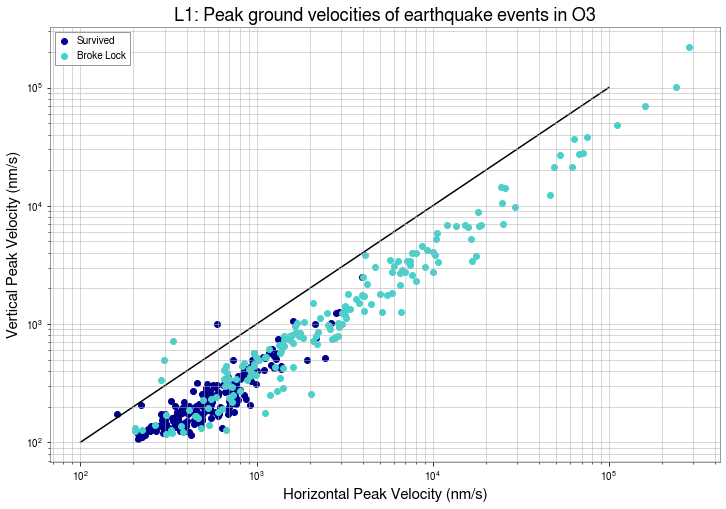

In [9]:
#plot magnitude of vertical vs. horizontal ground velocities
plt.figure(figsize=(12,8))
plt.title('L1: Peak ground velocities of earthquake events in O3', fontsize=18) #choose plot title

#plot survived and lostlock earthquake events
plt.scatter(totaldf[totaldf['Broke Lock']=='No']['Horiz. Vel.'], totaldf[totaldf['Broke Lock']=='No']['Vert. Vel.'],label='Survived', color='darkblue')
plt.scatter(totaldf[totaldf['Broke Lock']=='Yes']['Horiz. Vel.'], totaldf[totaldf['Broke Lock']=='Yes']['Vert. Vel.'],label='Broke Lock', color='mediumturquoise')
plt.plot([100,100000], [100, 100000], '-', color='black') #plot y=x to easily visualize how vert. and horiz. compare

plt.xlabel('Horizontal Peak Velocity (nm/s)', fontsize=15)
plt.ylabel('Vertical Peak Velocity (nm/s)',fontsize=15)
plt.legend()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="-")

plt.savefig(vel_plotname)
plt.show()

In [243]:
#set bins #choose your own parameters 
bins = np.logspace(2, 5.9, num=16)

In [244]:
#calculate probability of survival
survivedeq = totaldf[totaldf['Broke Lock']=='No']['Vert. Vel.'].value_counts(sort = False, bins = bins) #number of survived EQs
totaleq = totaldf['Vert. Vel.'].value_counts(sort = False, bins = bins) #total number of EQs

prob = survivedeq/totaleq

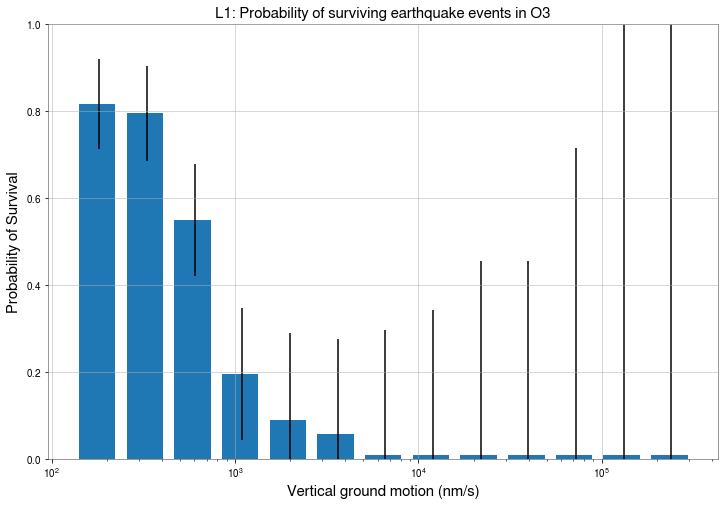

In [246]:
#plot histogram
dimw = np.diff(bins)

fig, ax = plt.subplots(figsize=(12,8))
x = bins[0:-1]
y = prob
yerr = 1/np.sqrt(totaleq.array)
b = ax.bar(x + dimw, y+0.01, dimw, bottom=-0.001, yerr=yerr, ls='none')

#ax.set_xticks(x + dimw / 2, labels=map(str, x))
ax.set_xscale('log')
ax.set_ylim(0, 1)
ax.set_xlabel('Vertical ground motion (nm/s)', fontsize=15)
ax.set_ylabel('Probability of Survival', fontsize=15)
ax.set_title('L1: Probability of surviving earthquake events in O3', fontsize=15)

plt.savefig(prob_plotname)
plt.show()

In [28]:
#list of GPS times of all earthquake peaks
eqtimes = totaldf['Time of Peak'].tolist()
eqtimes

[1238124198, 1238146998, 1238184438, 1238278998, 1238296158, 1238517798, 1238526438, 1238536098, 1238620758, 1238655498, 1238671818, 1238798898, 1238871318, 1239009918, 1239109758, 1239120678, 1239293838, 1239428598, 1239438498, 1239446718, 1239837918, 1239964458, 1239994338, 1240006158, 1240037178, 1240090338, 1240296918, 1240473978, 1240543518, 1240588038, 1240694358, 1240907538, 1240972278, 1241075478, 1241216718, 1241360238, 1241485338, 1241497938, 1241725338, 1241746158, 1241878878, 1241886198, 1241907018, 1241937558, 1241968698, 1242009138, 1242059718, 1242084198, 1242160878, 1242172158, 1242185478, 1242267858, 1242316638, 1242510018, 1242526278, 1242598578, 1242639078, 1242662538, 1242674058, 1242893058, 1242987858, 1243243038, 1243253778, 1243267518, 1243324458, 1243340298, 1243401678, 1243510458, 1243582458, 1243660098, 1244193978, 1244226138, 1244433378, 1244508678, 1244523078, 1244566038, 1244581878, 1244682798, 1244700678, 1244758038, 1244790498, 1244807238, 1244823198, 124

In [29]:
#times of earthquake events that break lock ("lockloss times")
ll_times = totaldf[totaldf['Broke Lock']=='Yes']['Time of Peak'].tolist()
ll_times

[1238278998, 1238517798, 1238526438, 1238536098, 1238620758, 1238798898, 1238871318, 1239009918, 1239109758, 1239120678, 1239293838, 1239964458, 1239994338, 1240006158, 1240037178, 1240090338, 1240473978, 1240543518, 1240588038, 1240694358, 1240907538, 1241216718, 1241360238, 1241485338, 1241497938, 1241725338, 1241878878, 1241886198, 1241937558, 1242059718, 1242084198, 1242160878, 1242185478, 1242267858, 1242316638, 1242639078, 1242893058, 1242987858, 1243243038, 1243340298, 1243510458, 1243582458, 1244508678, 1244682798, 1244700678, 1244790498, 1244823198, 1244903118, 1244913258, 1244928618, 1244966238, 1245004878, 1245145698, 1245229218, 1245244998, 1245279018, 1245298398, 1245384498, 1245415518, 1245435978, 1245491658, 1245553638, 1245562938, 1245672498, 1245776238, 1246128798, 1246165938, 1246251378, 1246297878, 1246368198, 1246419378, 1246441578, 1246552098, 1246651878, 1246973538, 1247003358, 1247105598, 1247123718, 1247136198, 1247217798, 1247412258, 1248224478, 1248588498, 124